In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import spectrum
from pyleoclim import Spectral
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from tqdm import tqdm

In [2]:
def run_periodogram(series, xlim=[0, 0.05], label='PSD', loglog=False, title=None, detrend=False):
    time = series.index.values
    signal = series.values
    tau = np.linspace(np.min(time), np.max(time), 51)
    sa = Spectral.SpectralAnalysis()
    res_psd = sa.periodogram(signal, time, prep_args={'detrend': detrend})
    
    sns.set(style='ticks', font_scale=1.5)
    fig = plt.figure(figsize=[10, 10])                                                                                                                                           
    ax_signal = plt.subplot(2, 1, 1)
    ax_signal.plot(time, signal, label='signal')                                                                                                                                                          
    ax_signal.spines['right'].set_visible(False)
    ax_signal.spines['top'].set_visible(False)
    ax_signal.set_ylabel('Value')
    ax_signal.set_xlabel('Time')
    if title:
        ax_signal.set_title(title)
    
    ax_spec = plt.subplot(2, 1, 2)
    if loglog:
        ax_spec.loglog(res_psd['freqs'], res_psd['psd'], lw=3, label=label)                                                                                                                                                          
    else:
        ax_spec.plot(res_psd['freqs'], res_psd['psd'], lw=3, label=label)                                                                                                                                                          
        ax_spec.set_xlim(xlim)
        
    ax_spec.get_xaxis().set_major_formatter(ScalarFormatter())
    ax_spec.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax_spec.set_ylabel('Spectral Density')                                                                                                                                                 
    ax_spec.set_xlabel('Frequency')                                                                                                                                                   
    ax_spec.legend(frameon=False)
    ax_spec.spines['right'].set_visible(False)
    ax_spec.spines['top'].set_visible(False)
    
    return fig, res_psd

# creat a DataFrame to store the data
df = pd.DataFrame()

In [3]:
def colored_noise(alpha, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries
    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

def colored_noise_2regimes(alpha1, alpha2, f_break, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries with two regimes
    Args:
        alpha1, alpha2 (float): the exponent of the 1/f^alpha noise
        f_break (float): the frequency where the scaling breaks
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2  # so the aliasing is limited

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase

    f_vec = k*f0
    regime1= k*f0>=f_break
    regime2= k*f0<=f_break
    f_vec1 = f_vec[regime1]
    f_vec2 = f_vec[regime2]
    s = np.exp(alpha1/alpha2*np.log(f_vec1[0])) / f_vec2[-1]

    for j in range(n):
        coeff = np.ndarray((np.size(f_vec)))
        coeff[regime1] = f_vec1**(-alpha1/2)
        coeff[regime2] = (s*f_vec2)**(-alpha2/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

## Constant frequency signal

1001


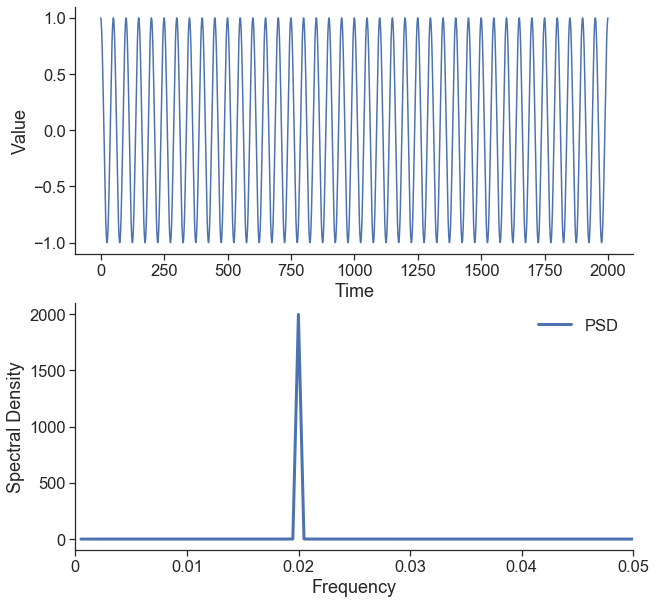

In [4]:
time = np.arange(2001)
f = 1/50
signal = np.cos(2*np.pi*f*time)

series = pd.Series(signal, index=time)
df['const_freq'] = series

fig, res_psd = run_periodogram(series)
print(np.size(res_psd['freqs']))

## Two constant frequencies

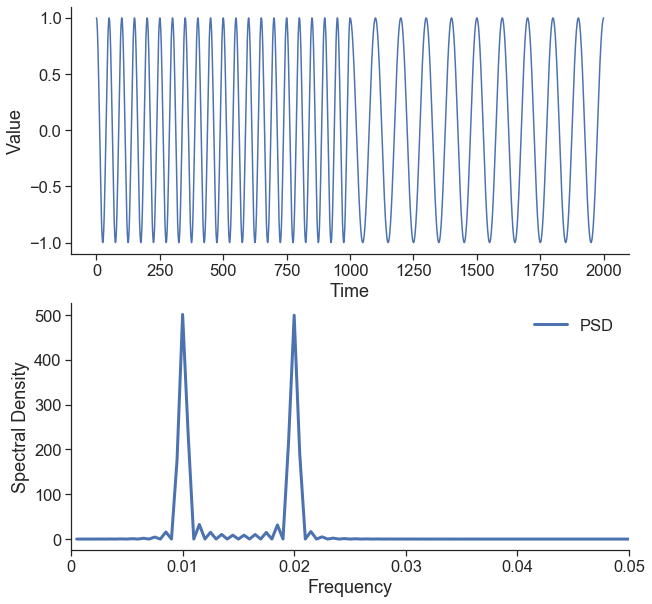

In [5]:
time1 = np.arange(1000)
f1 = 1/50
signal1 = np.cos(2*np.pi*f1*time1)

time2 = np.arange(1000, 2001)
f2 = 1/100
signal2 = np.cos(2*np.pi*f2*time2)

signal = np.concatenate([signal1, signal2])
time = np.concatenate([time1, time2])

series = pd.Series(signal, index=time)
df['two_freqs'] = series

fig, res_psd = run_periodogram(series)

## Two close constant frequencies

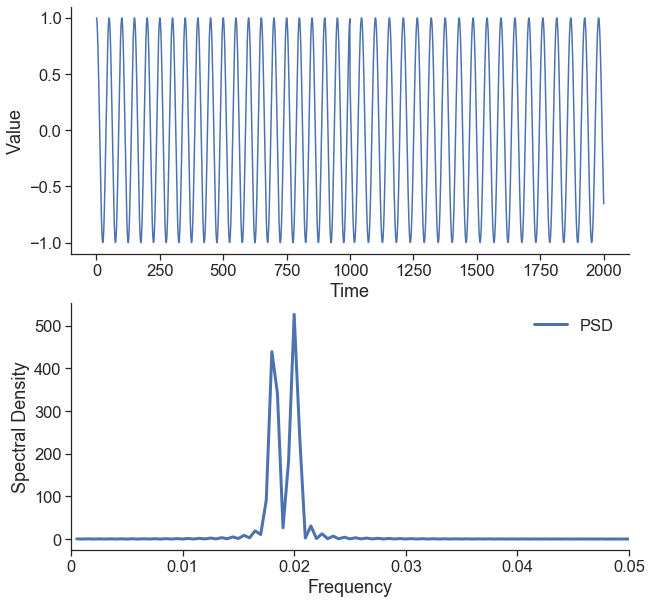

In [6]:
time1 = np.arange(1000)
f1 = 1/50
signal1 = np.cos(2*np.pi*f1*time1)

time2 = np.arange(1000, 2001)
f2 = 1/55
signal2 = np.cos(2*np.pi*f2*time2)

signal = np.concatenate([signal1, signal2])
time = np.concatenate([time1, time2])

series = pd.Series(signal, index=time)
df['two_close_freqs'] = series

fig, res_psd = run_periodogram(series)

## Colored noise

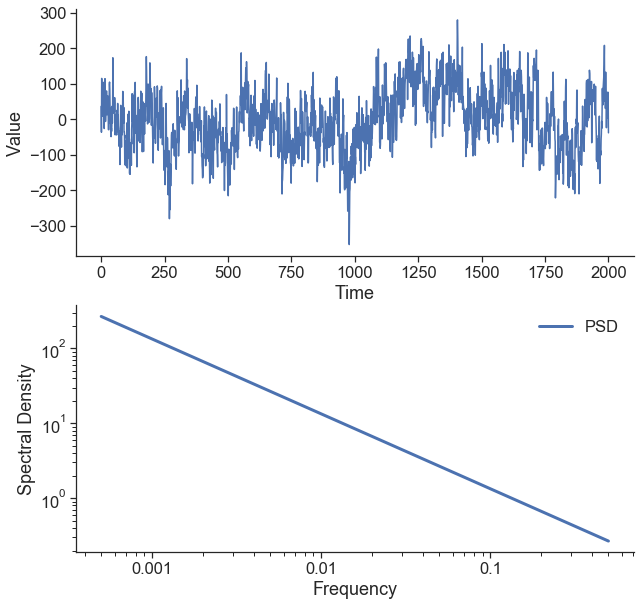

In [7]:
time = np.arange(2001)
signal = colored_noise(1, time, seed=2333)

series = pd.Series(signal, index=time)
df['colored_beta1'] = series

fig, res_psd = run_periodogram(series, loglog=True)

## Colored noise with two regiems

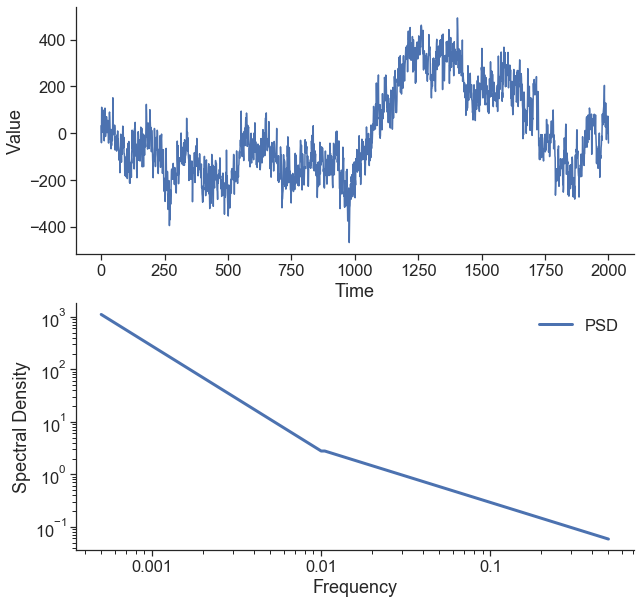

In [8]:
time = np.arange(2001)
signal = colored_noise_2regimes(1, 2, 1/100, time, seed=2333)

series = pd.Series(signal, index=time)
df['colored_beta1_2regimes'] = series

fig, res_psd = run_periodogram(series, loglog=True)

## add trend

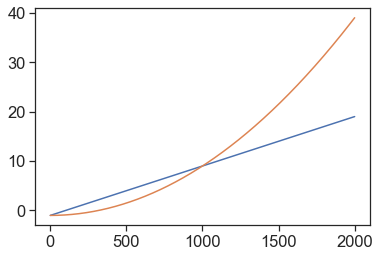

In [9]:
time = np.arange(2001)
slope = 0.01
intercept = -1
linear_trend = slope*time + intercept

slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept

plt.plot(time, linear_trend, label='linear_trend')
plt.plot(time, nonlinear_trend, label='nonlinear_trend')

# signal = df['const_freq'].values
# time = df['const_freq'].index
# signal_linearTrend = signal + linear_trend
# signal_nonlinearTrend = signal + nonlinear_trend

# plt.plot(time, signal_linearTrend, label='linear_trend')
# plt.plot(time, signal_nonlinearTrend, label='nonlinear_trend')

# from pyleoclim import Timeseries
# wa = Spectral.WaveletAnalysis()

# output = wa.preprocess(signal_linearTrend, time, detrend='linear', standardize=False)
# plt.plot(time, output, label='linear (linear)')

# output = wa.preprocess(signal_linearTrend, time, detrend='savitzy-golay', standardize=False, params=['default', 4, 0, 1])
# plt.plot(time, output, label='linear (Savitzy-Golay)')

# output = wa.preprocess(signal_nonlinearTrend, time, detrend='savitzy-golay', standardize=False)
# plt.plot(time, output, label='nonlinear (Savitzy-Golay)')

# plt.legend(frameon=False)

 60%|██████    | 3/5 [00:00<00:00, 24.30it/s]

['const_freq' 'two_freqs' 'two_close_freqs' 'colored_beta1'
 'colored_beta1_2regimes']


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


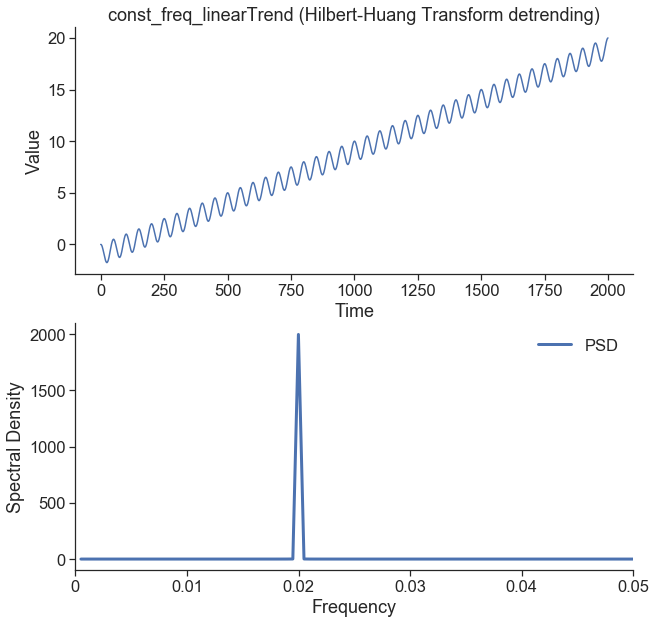

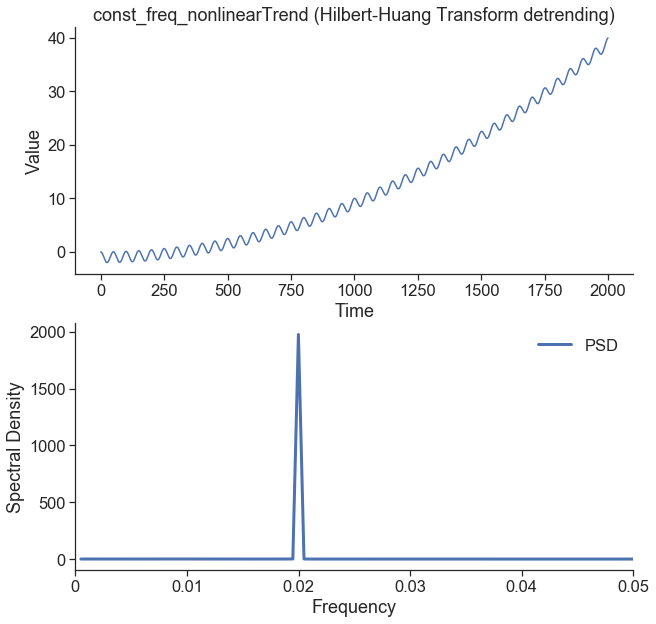

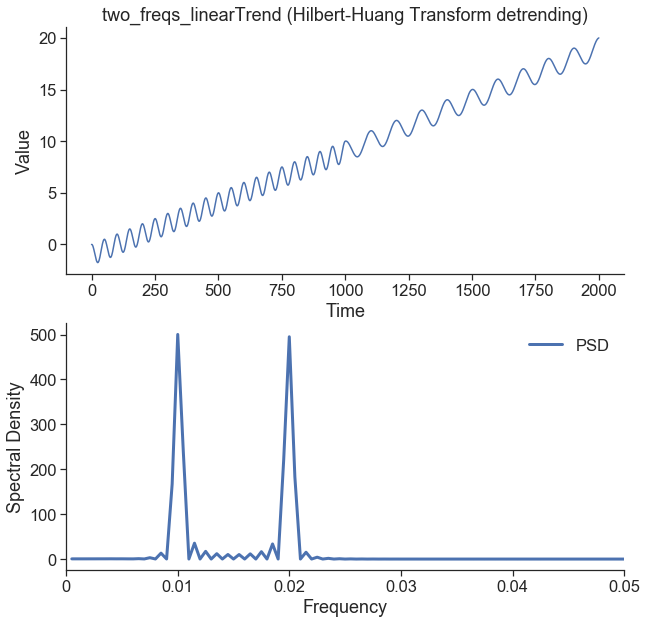

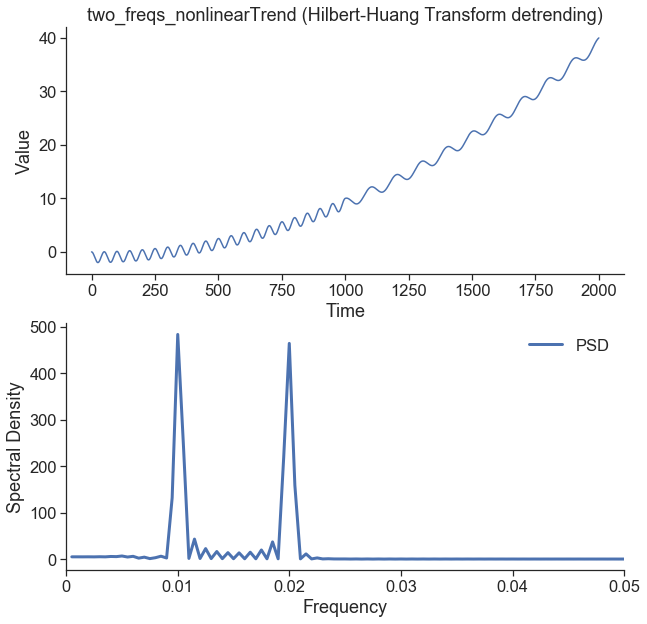

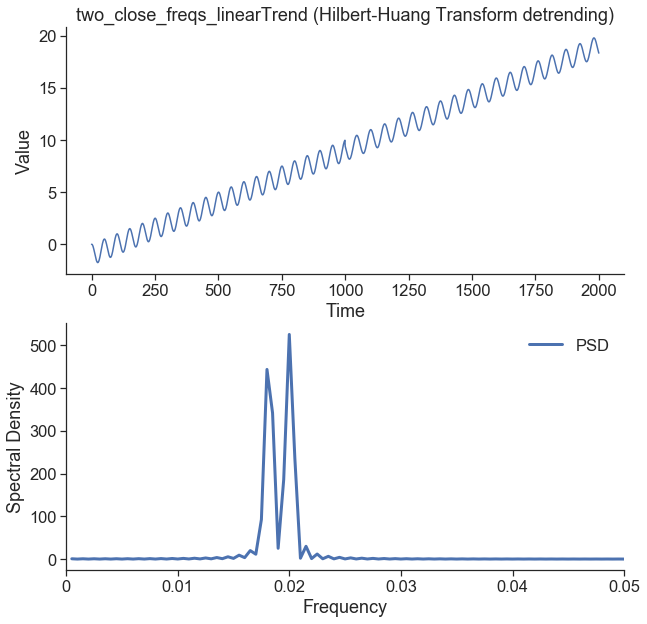

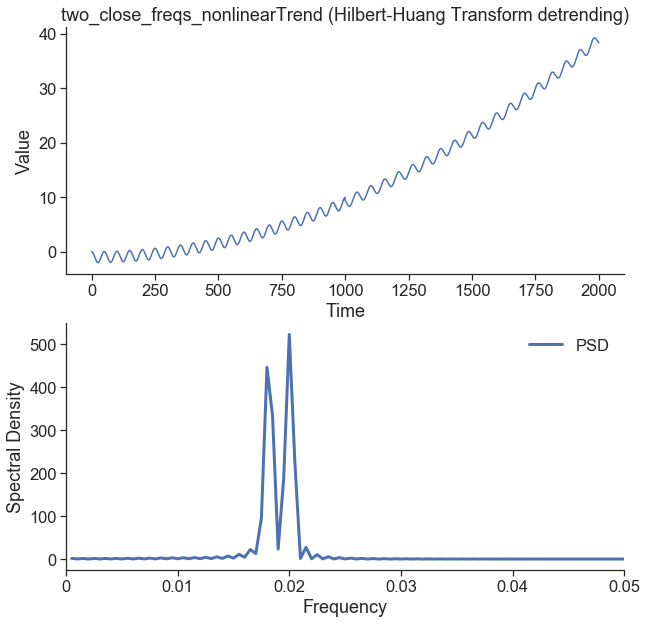

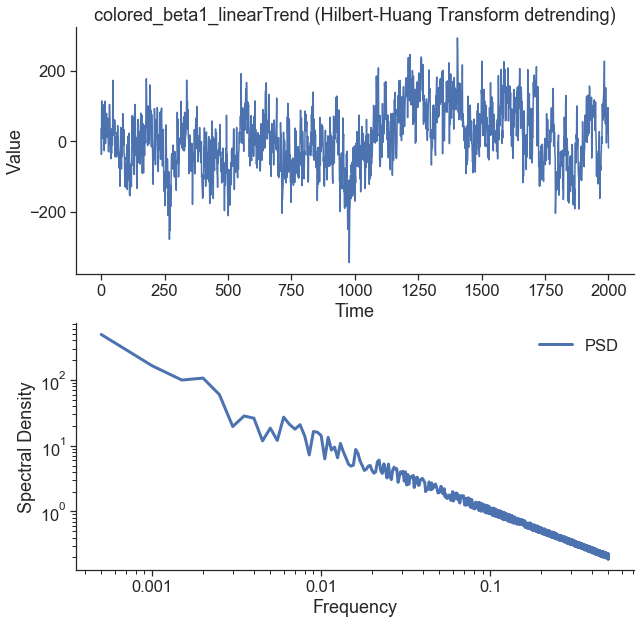

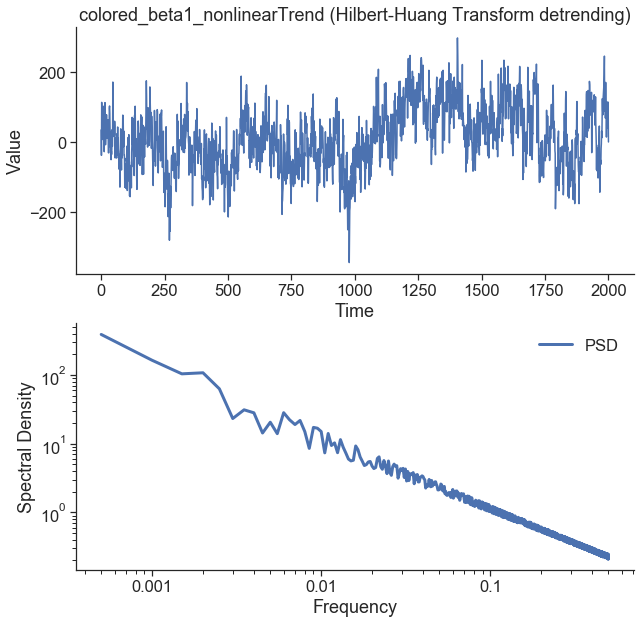

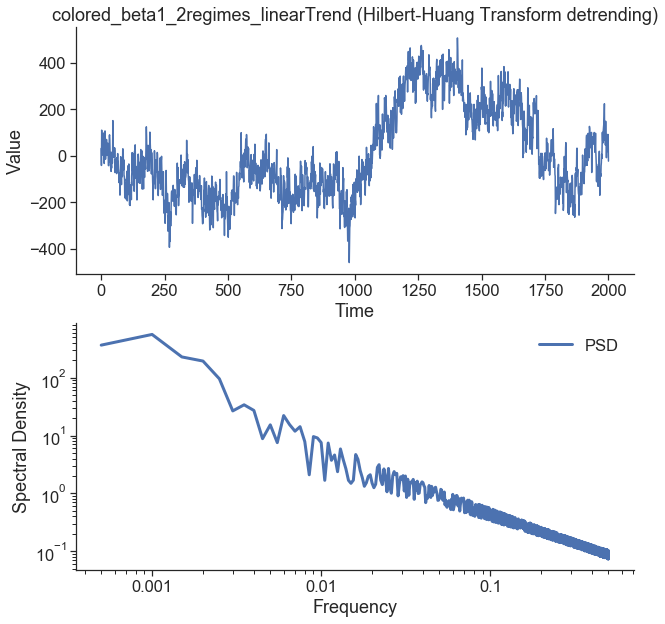

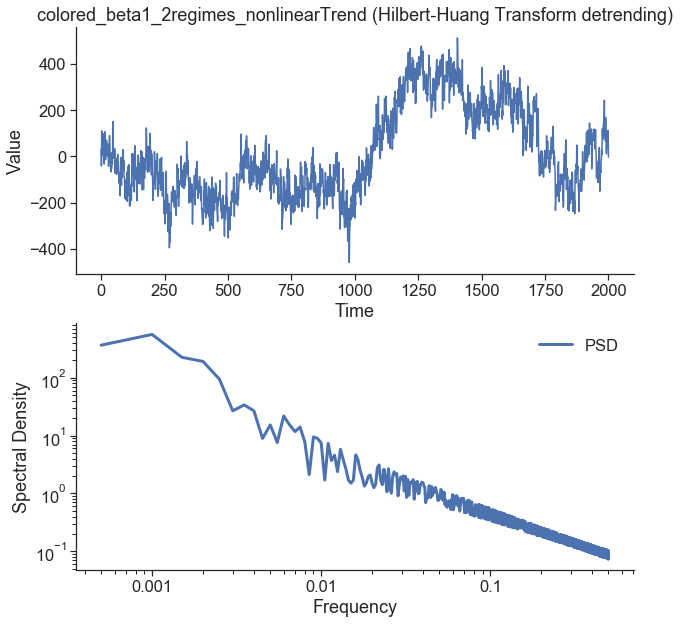

In [10]:
case_list = df.columns.values
print(case_list)
for case_tag in tqdm(case_list):
    signal = df[case_tag].values
    time = df[case_tag].index
    
    signal_trend = signal + linear_trend
    series = pd.Series(signal_trend, index=time)
    col_tag = f'{case_tag}_linearTrend'
    df[col_tag] = series
    
    if 'colored' in case_tag:
        loglog=True
    else:
        loglog=False
            
#     fig, res_psd = run_periodogram(series, title=f'{col_tag} (no detrending)', detrend=False, loglog=loglog)
#     fig, res_psd = run_periodogram(series, title=f'{col_tag} (linear detrending)', detrend='linear', loglog=loglog)
#     fig, res_psd = run_periodogram(series, title=f'{col_tag} (Savitzy-Golay detrending)', detrend='savitzy-golay', loglog=loglog)
    fig, res_psd = run_periodogram(series, title=f'{col_tag} (Hilbert-Huang Transform detrending)', detrend='hht', loglog=loglog)
    
    signal_trend = signal + nonlinear_trend
    series = pd.Series(signal_trend, index=time)
    col_tag = f'{case_tag}_nonlinearTrend'
    df[col_tag] = series
#     fig, res_psd = run_periodogram(series, title=f'{col_tag} (no detrending)', detrend=False, loglog=loglog)
#     fig, res_psd = run_periodogram(series, title=f'{col_tag} (linear detrending)', detrend='linear', loglog=loglog)
#     fig, res_psd = run_periodogram(series, title=f'{col_tag} (Savitzy-Golay detrending)', detrend='savitzy-golay', loglog=loglog)
    fig, res_psd = run_periodogram(series, title=f'{col_tag} (Hilbert-Huang Transform detrending)', detrend='hht', loglog=loglog)

## add white noise with different SNRs

 13%|█▎        | 2/15 [00:00<00:01, 12.65it/s]

['const_freq' 'two_freqs' 'two_close_freqs' 'colored_beta1'
 'colored_beta1_2regimes' 'const_freq_linearTrend'
 'const_freq_nonlinearTrend' 'two_freqs_linearTrend'
 'two_freqs_nonlinearTrend' 'two_close_freqs_linearTrend'
 'two_close_freqs_nonlinearTrend' 'colored_beta1_linearTrend'
 'colored_beta1_nonlinearTrend' 'colored_beta1_2regimes_linearTrend'
 'colored_beta1_2regimes_nonlinearTrend']


100%|██████████| 15/15 [00:01<00:00, 11.45it/s]


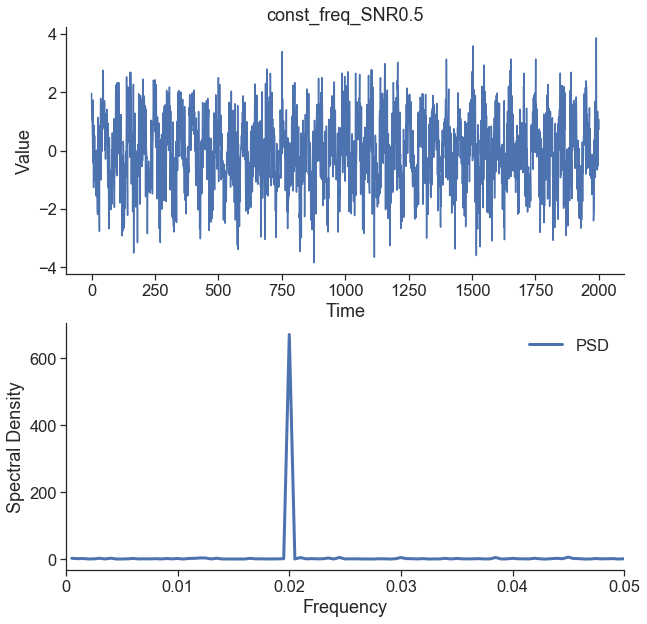

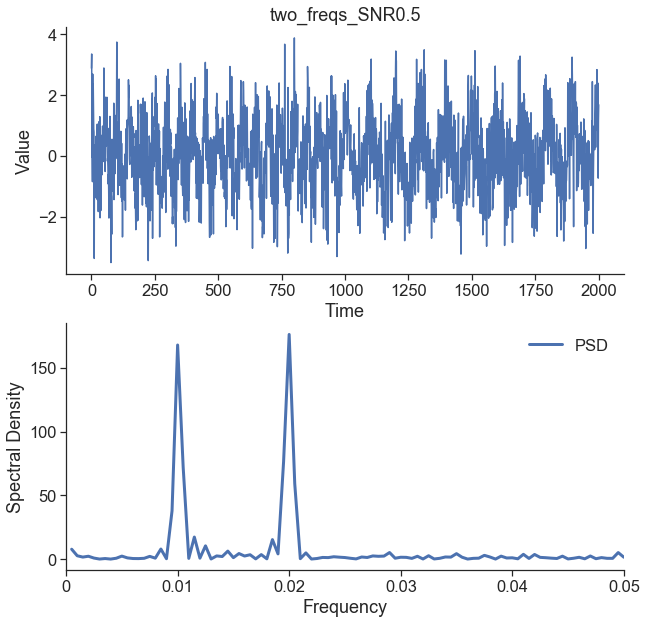

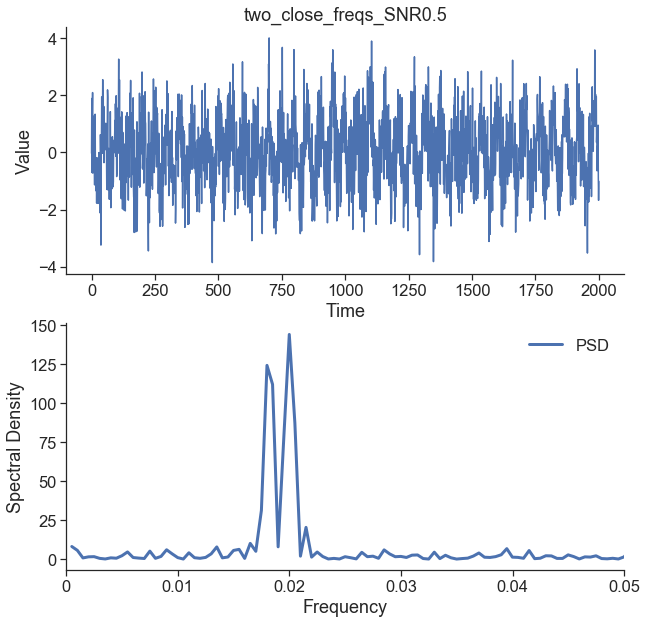

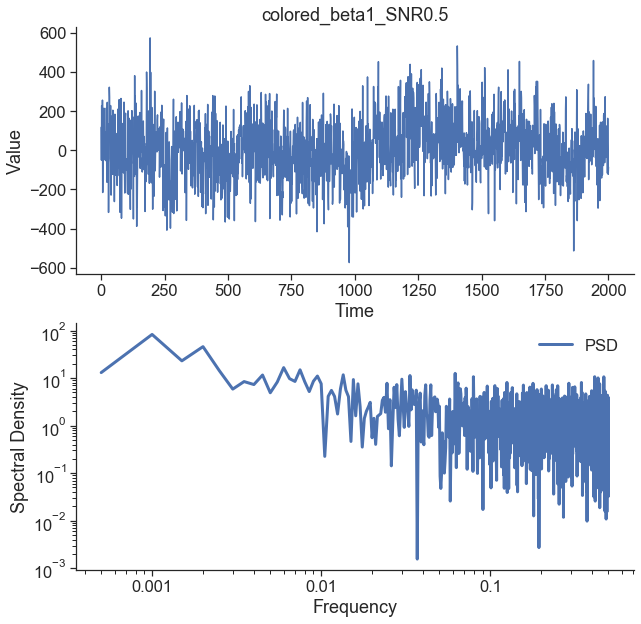

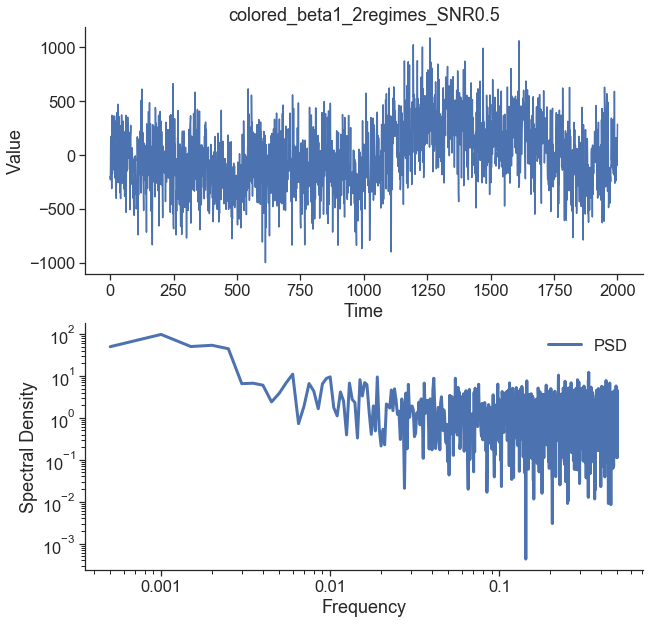

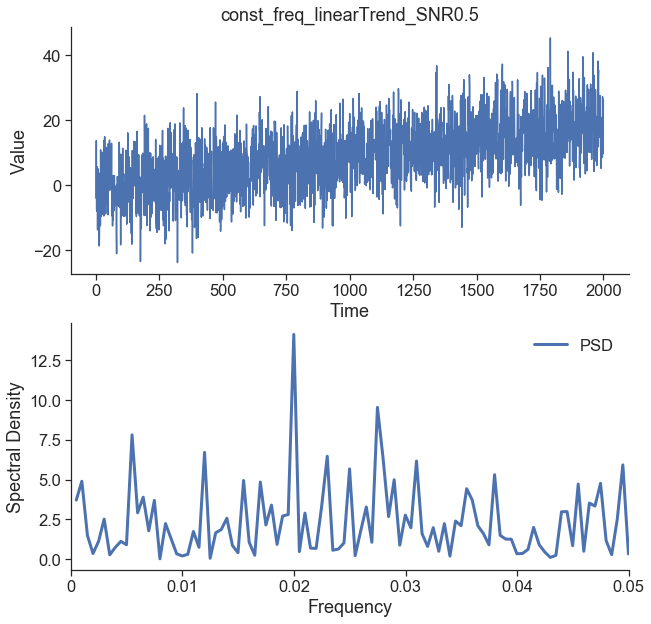

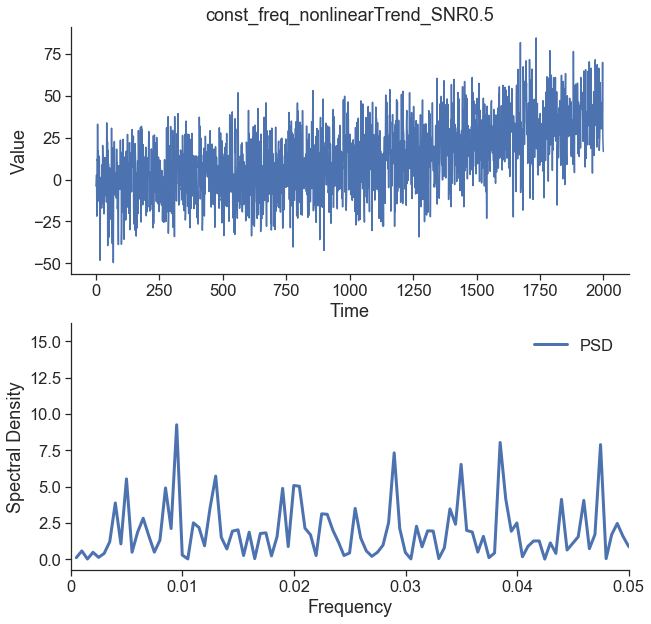

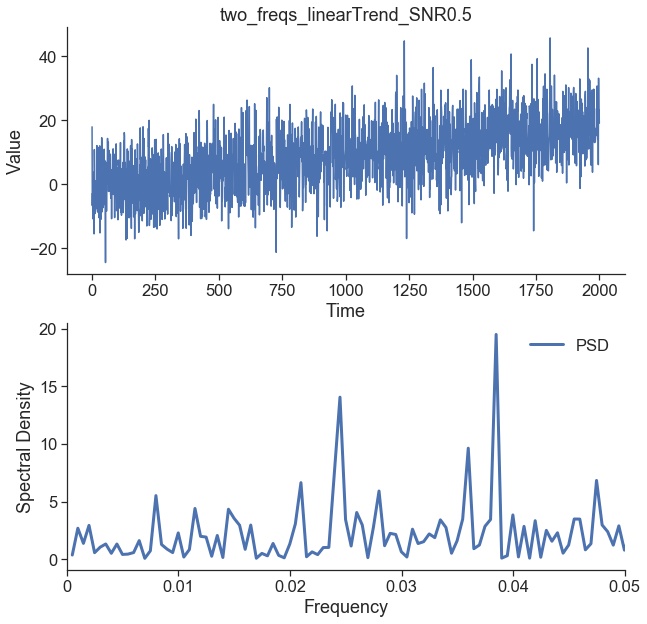

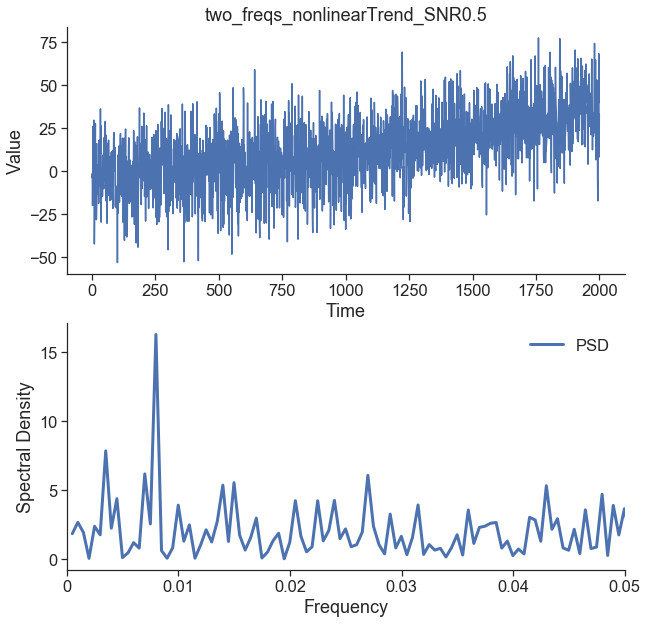

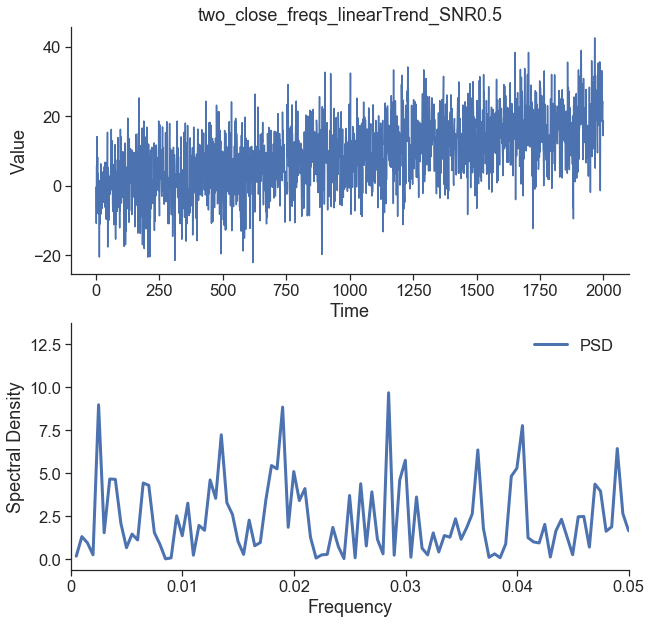

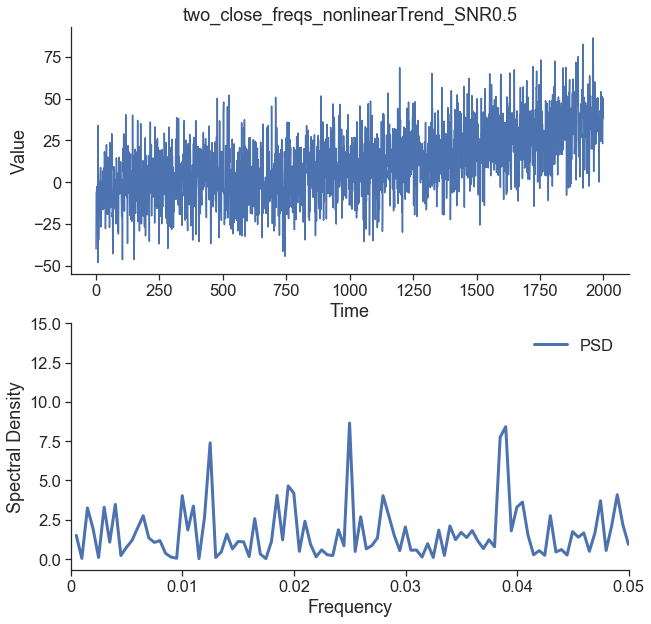

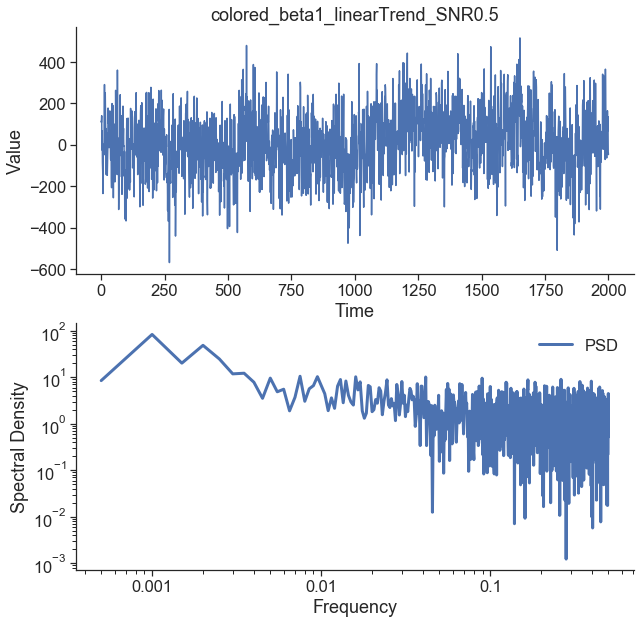

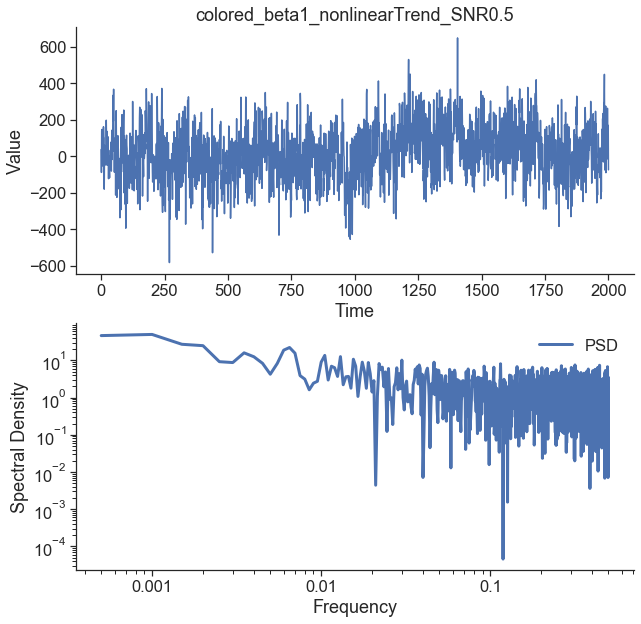

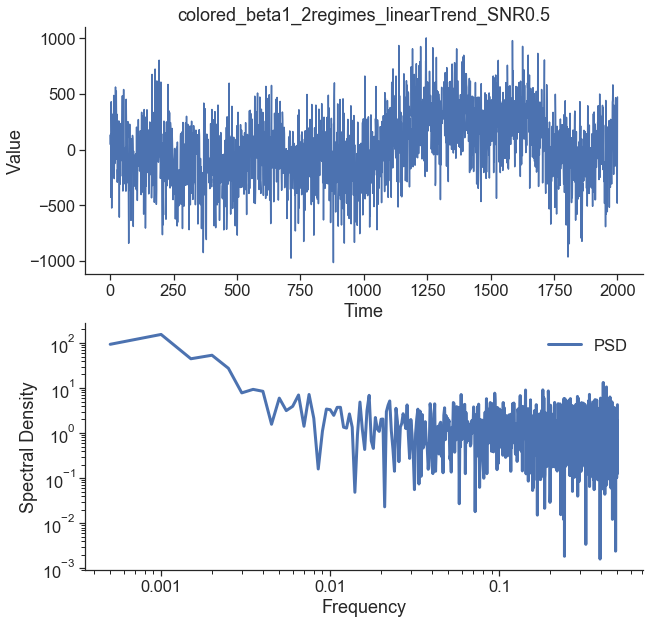

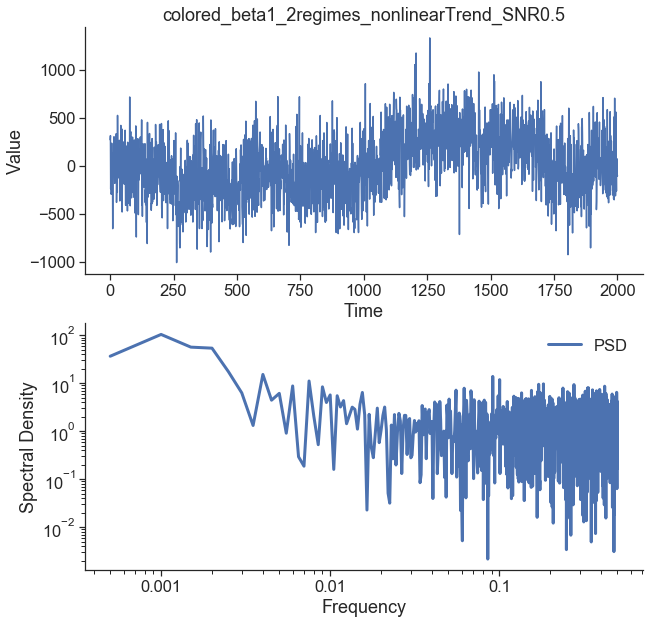

In [11]:
np.random.seed(2333)
case_list = df.columns.values
print(case_list)
for case_tag in tqdm(case_list):
    for SNR in [0.5]:
        signal = df[case_tag].values
        time = df[case_tag].index
        sig_var = np.var(signal)
        noise_var = sig_var / SNR
        white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
        signal_noise = signal + white_noise
        series = pd.Series(signal_noise, index=time)
        
        col_tag = f'{case_tag}_SNR{SNR}'
        df[col_tag] = series
        
        if 'colored' in case_tag:
            loglog=True
        else:
            loglog=False
            
        fig, res_psd = run_periodogram(series, title=col_tag, loglog=loglog, detrend='hht')

## randomly delete data points

  0%|          | 0/30 [00:00<?, ?it/s]

['const_freq' 'two_freqs' 'two_close_freqs' 'colored_beta1'
 'colored_beta1_2regimes' 'const_freq_linearTrend'
 'const_freq_nonlinearTrend' 'two_freqs_linearTrend'
 'two_freqs_nonlinearTrend' 'two_close_freqs_linearTrend'
 'two_close_freqs_nonlinearTrend' 'colored_beta1_linearTrend'
 'colored_beta1_nonlinearTrend' 'colored_beta1_2regimes_linearTrend'
 'colored_beta1_2regimes_nonlinearTrend' 'const_freq_SNR0.5'
 'two_freqs_SNR0.5' 'two_close_freqs_SNR0.5' 'colored_beta1_SNR0.5'
 'colored_beta1_2regimes_SNR0.5' 'const_freq_linearTrend_SNR0.5'
 'const_freq_nonlinearTrend_SNR0.5' 'two_freqs_linearTrend_SNR0.5'
 'two_freqs_nonlinearTrend_SNR0.5' 'two_close_freqs_linearTrend_SNR0.5'
 'two_close_freqs_nonlinearTrend_SNR0.5'
 'colored_beta1_linearTrend_SNR0.5' 'colored_beta1_nonlinearTrend_SNR0.5'
 'colored_beta1_2regimes_linearTrend_SNR0.5'
 'colored_beta1_2regimes_nonlinearTrend_SNR0.5']


 30%|███       | 9/30 [00:01<00:03,  6.02it/s]

Mode 4, Iteration 600
1 minima > 0; 17 maxima < 0.


 67%|██████▋   | 20/30 [00:01<00:00, 11.00it/s]/home/fzhu/Apps/miniconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
100%|██████████| 30/30 [00:02<00:00, 11.64it/s]


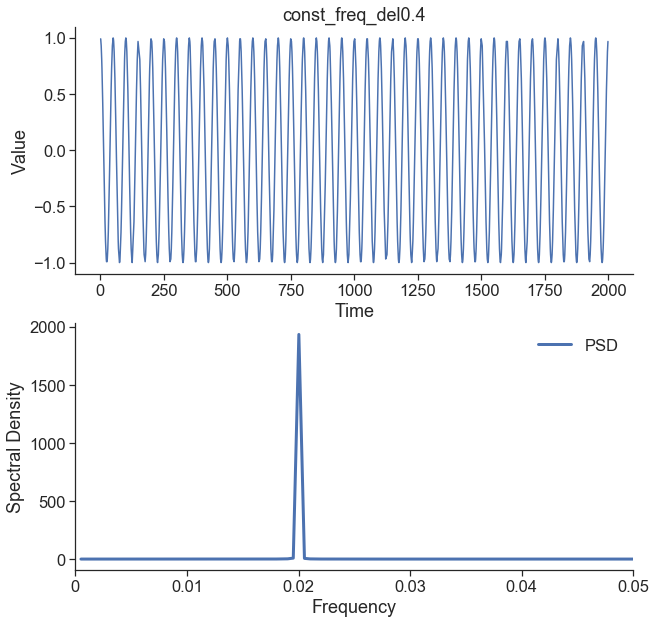

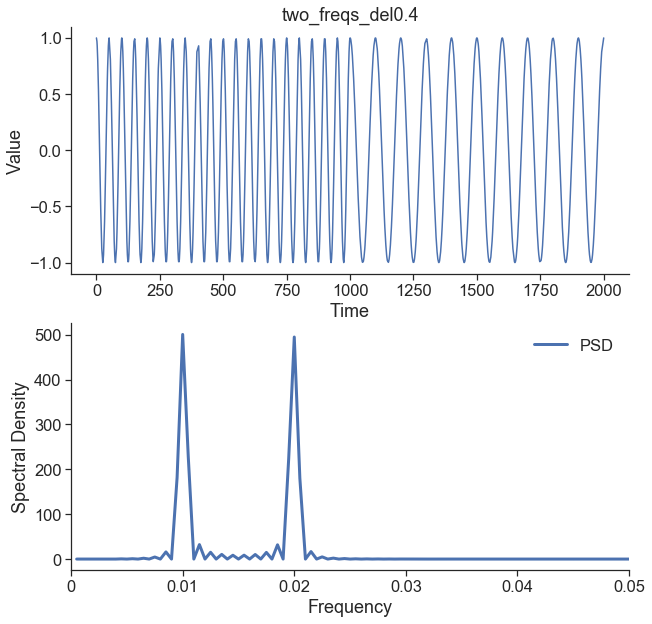

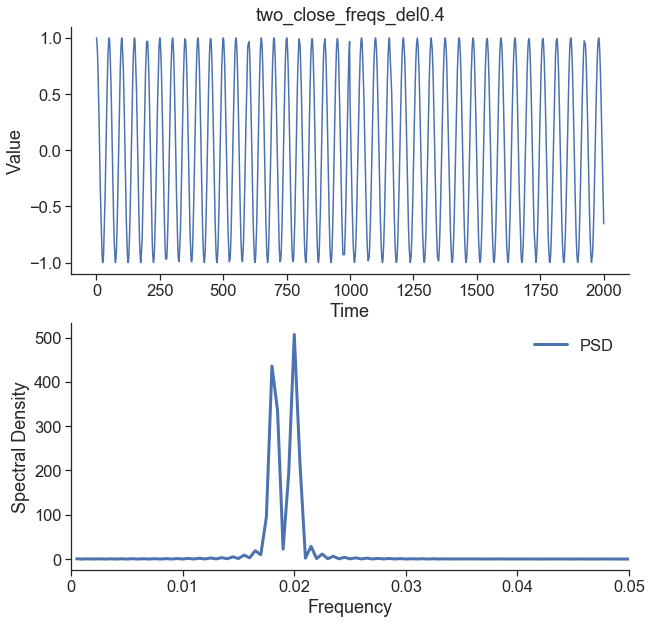

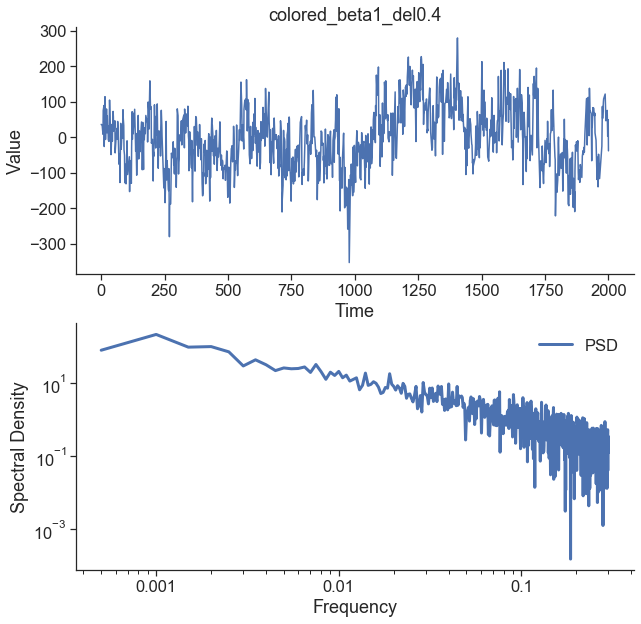

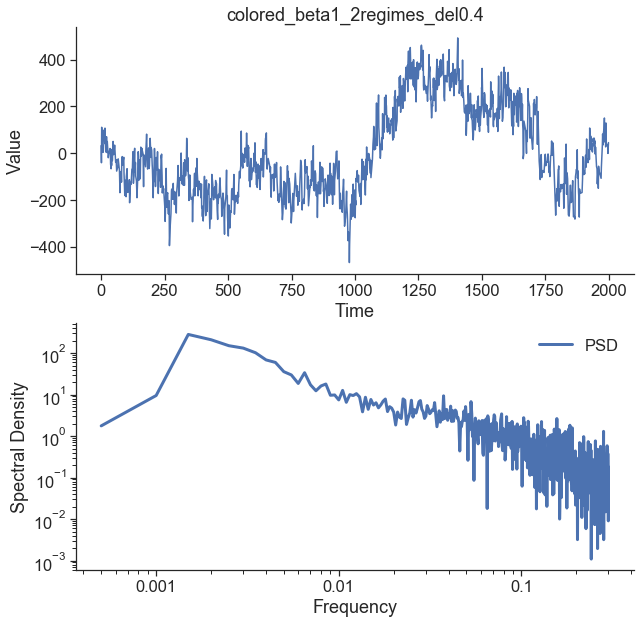

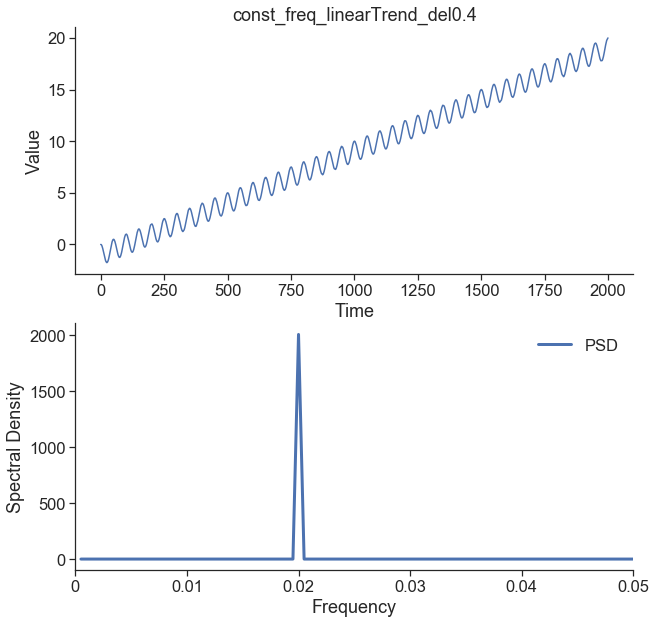

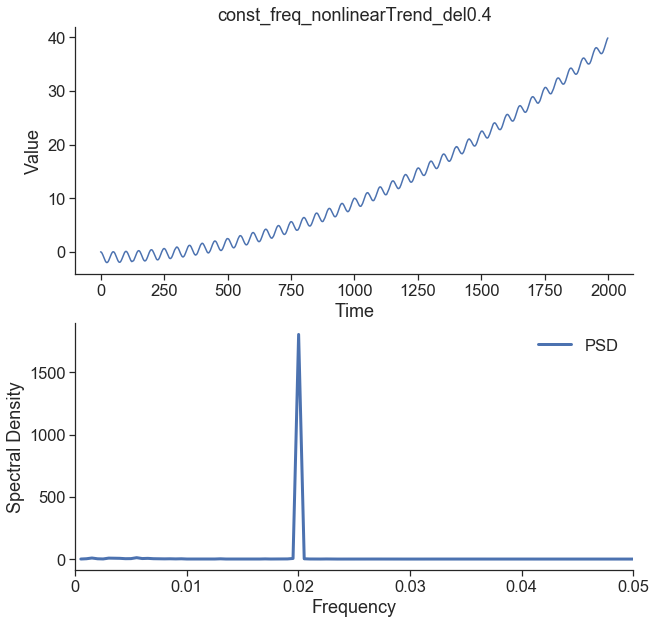

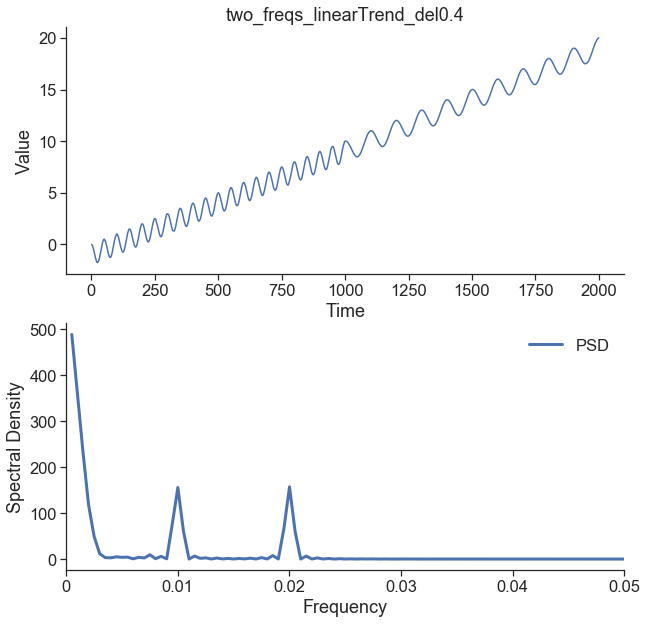

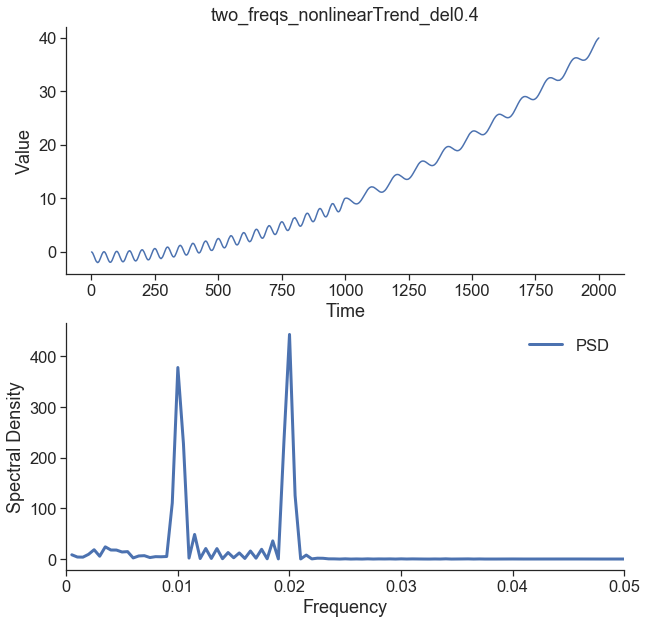

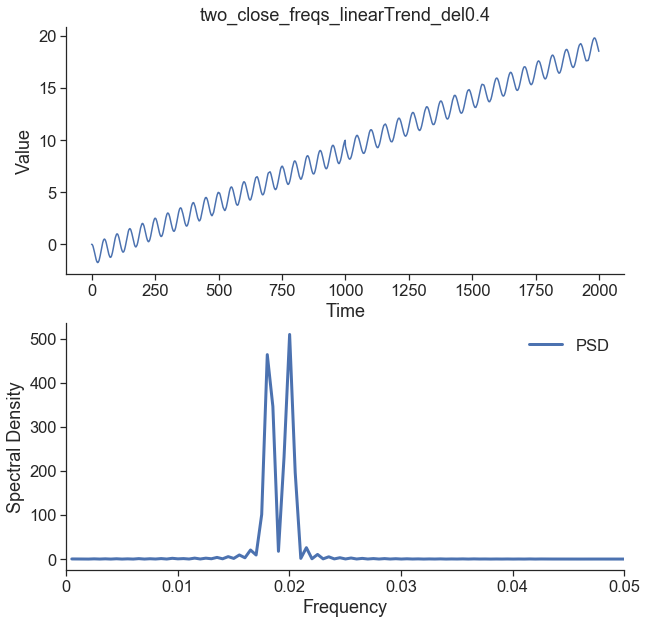

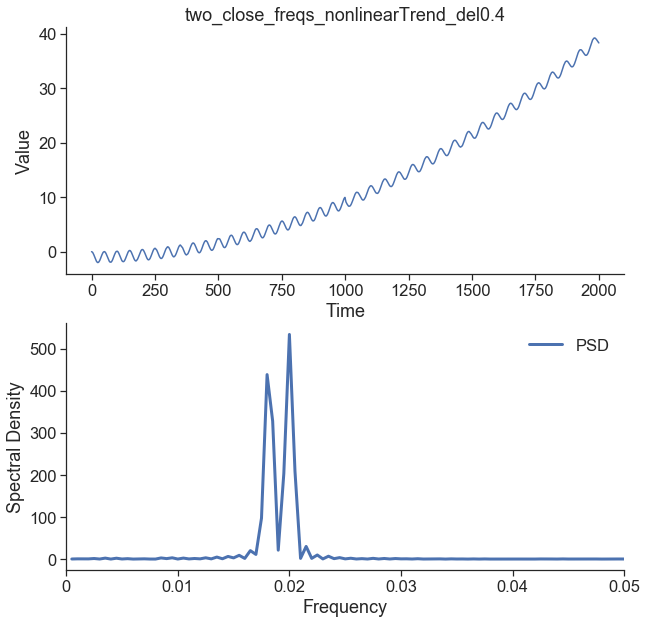

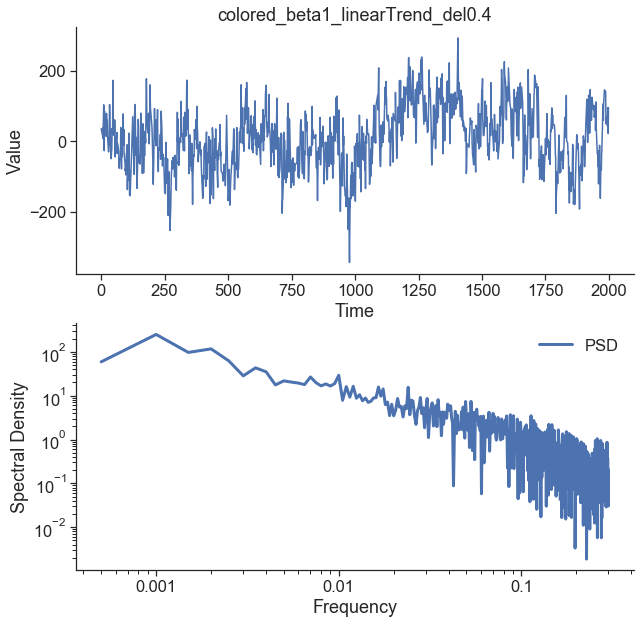

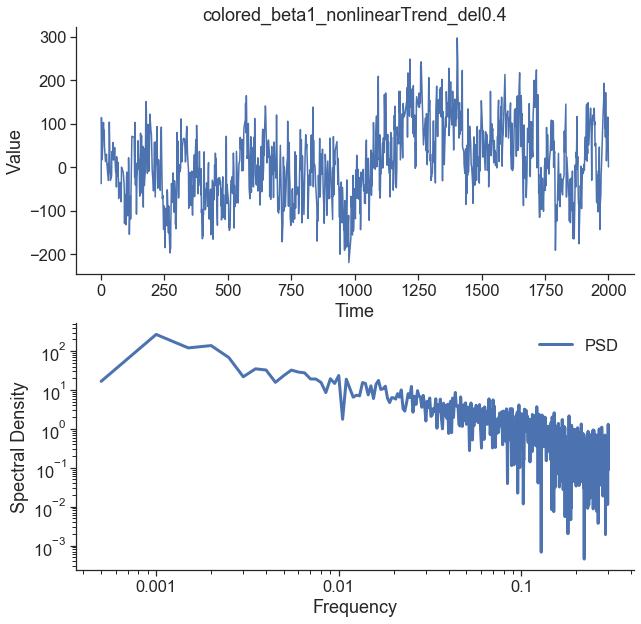

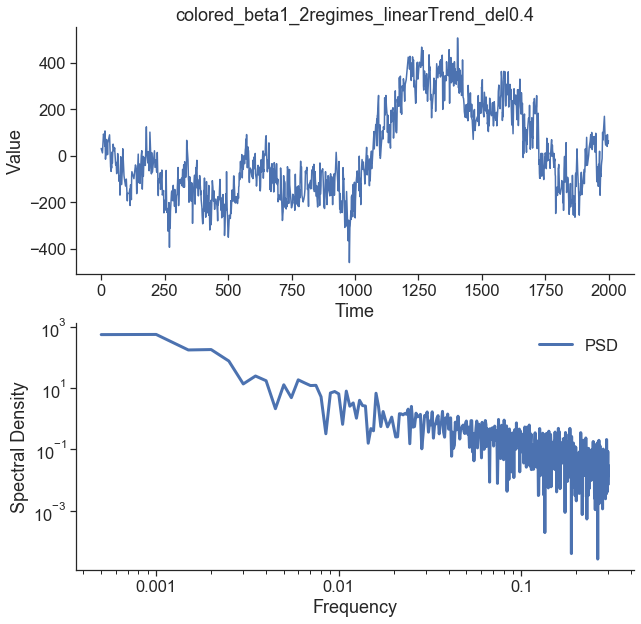

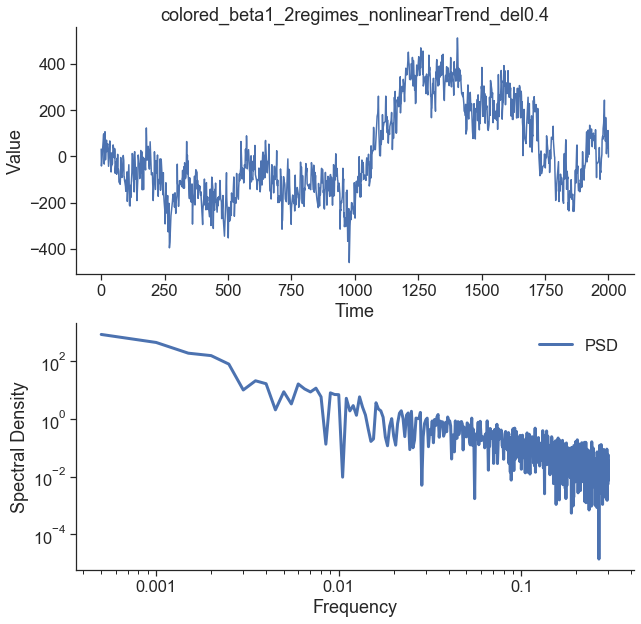

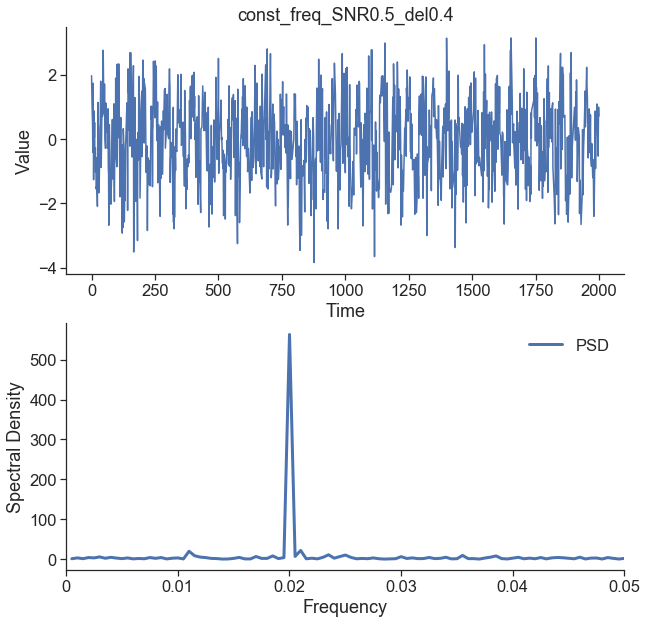

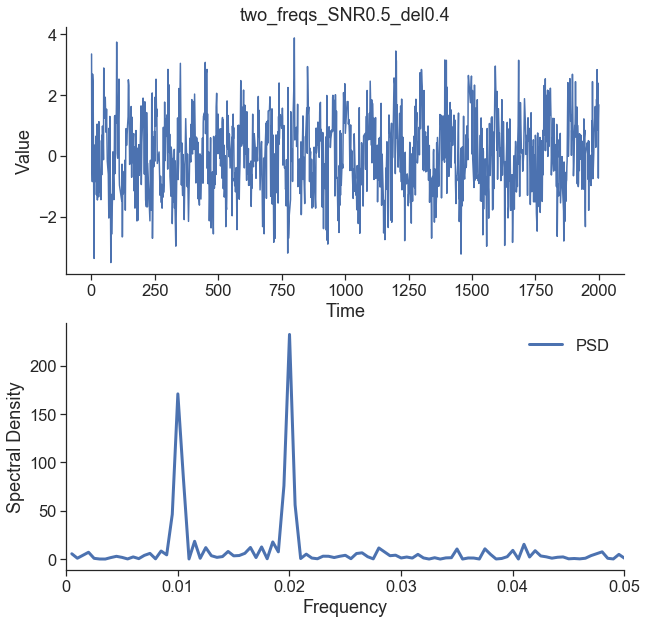

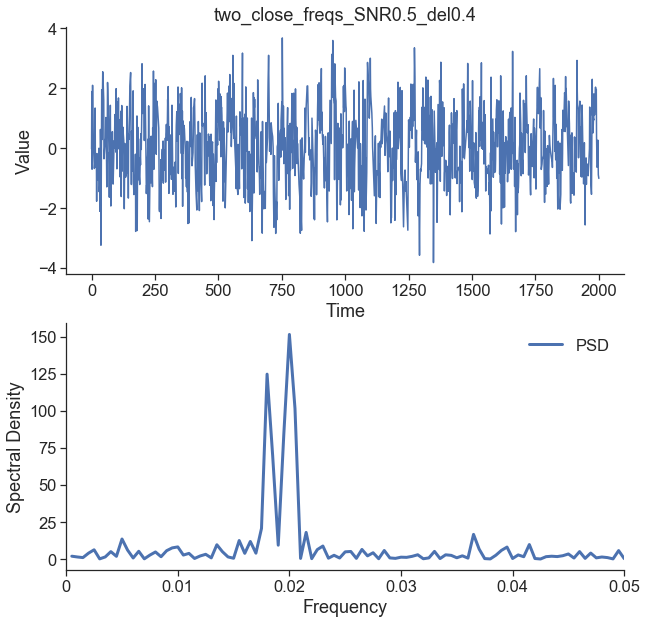

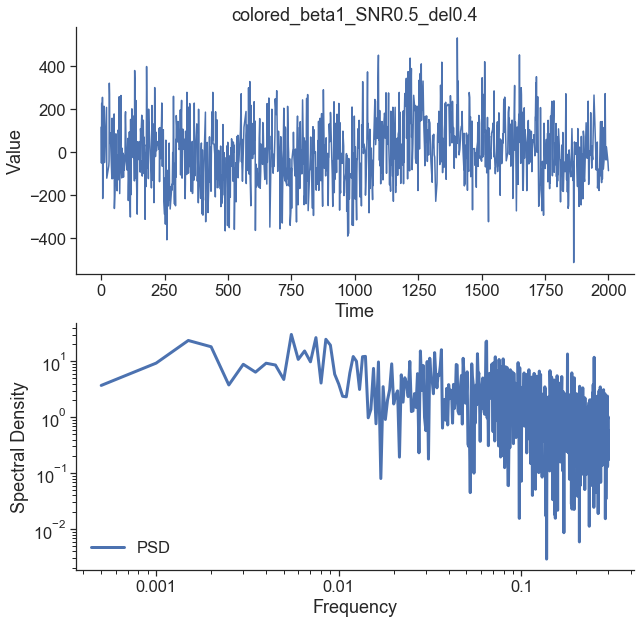

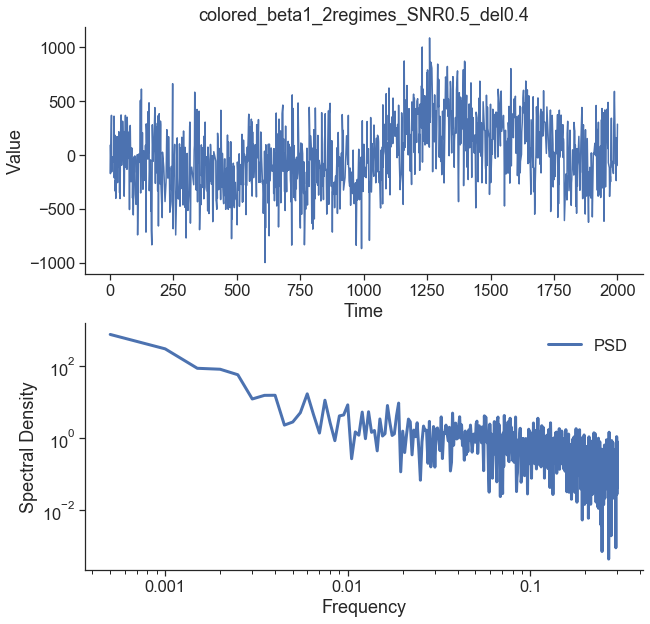

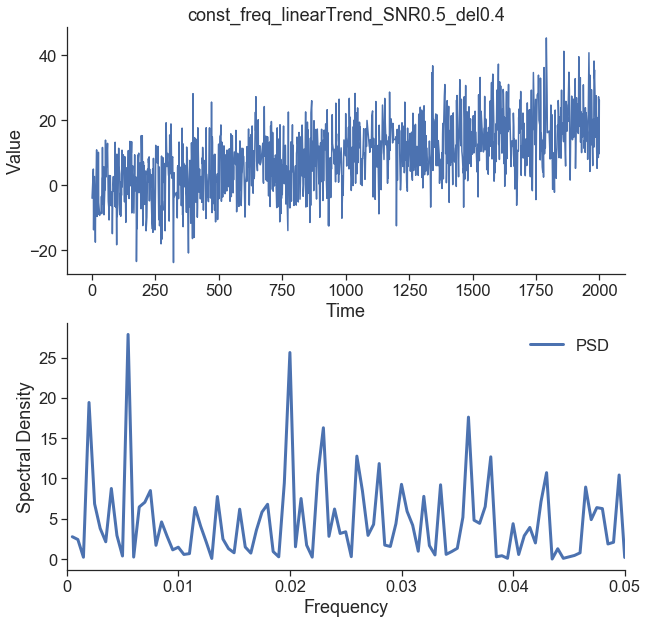

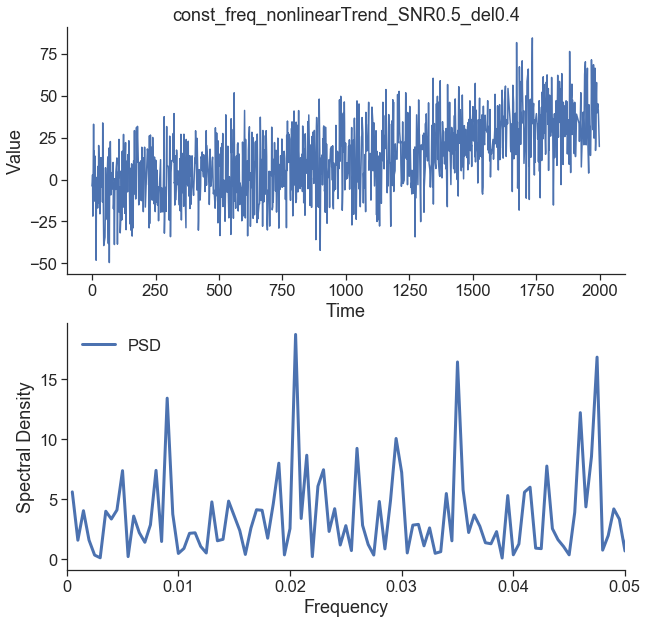

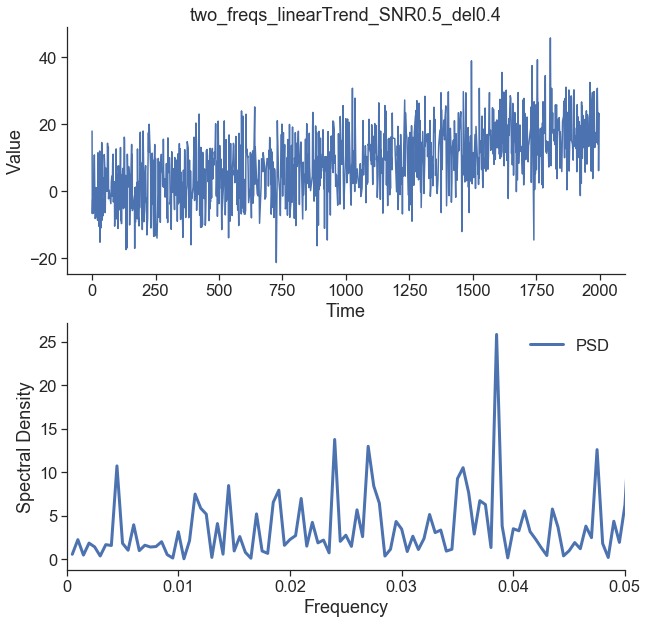

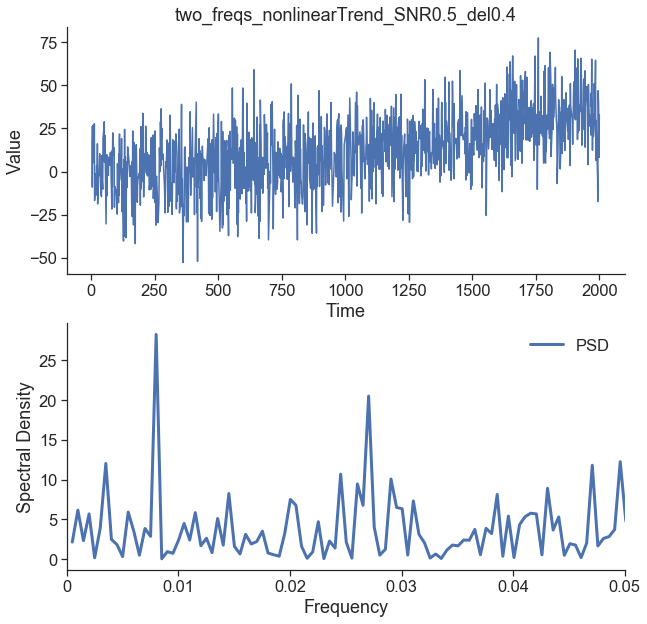

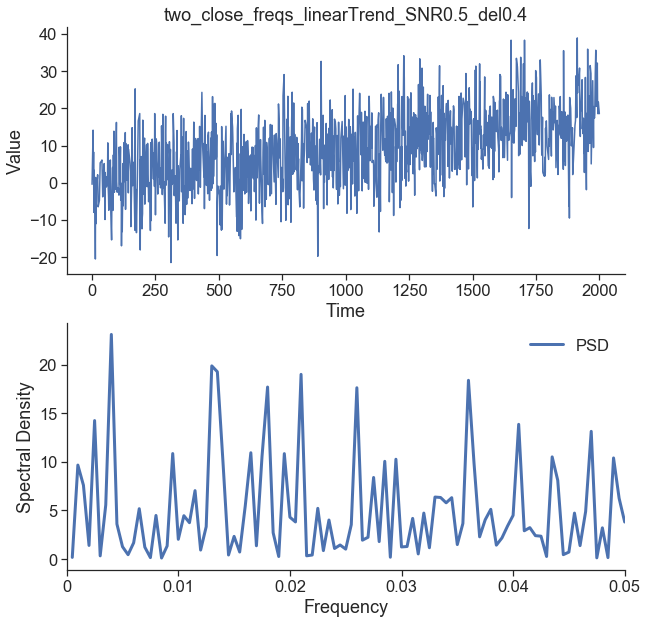

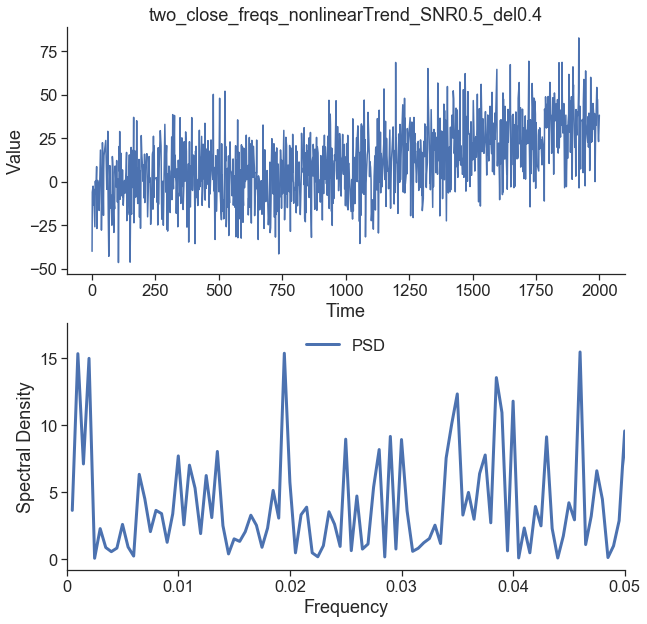

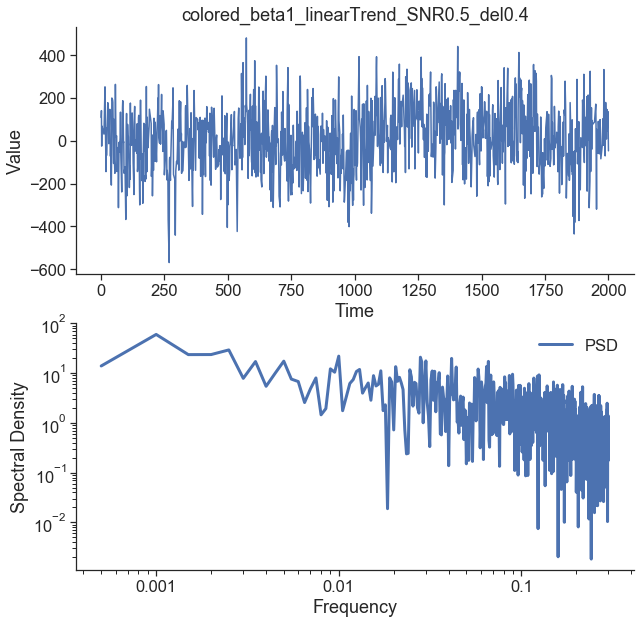

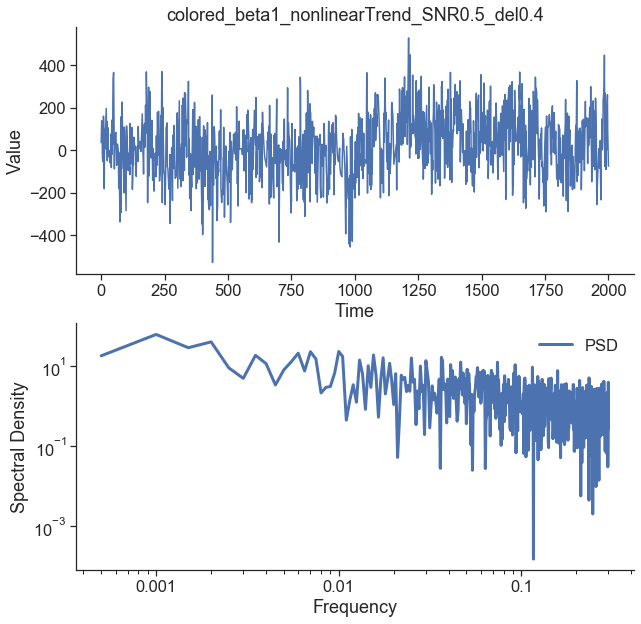

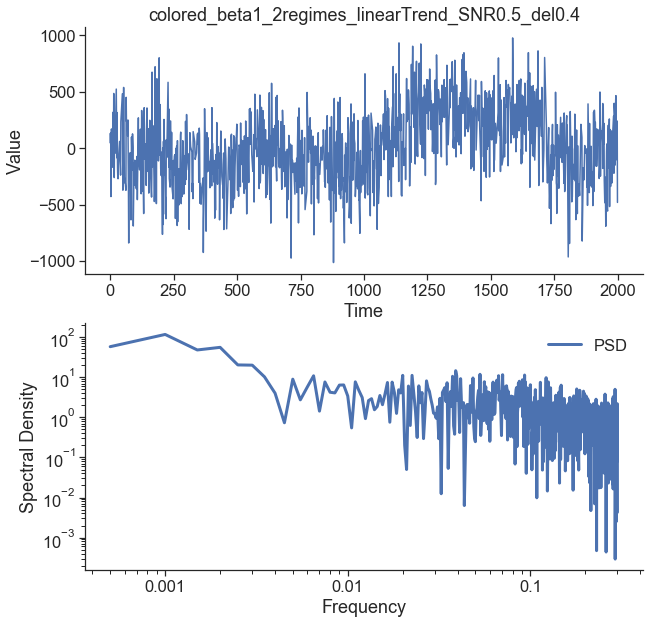

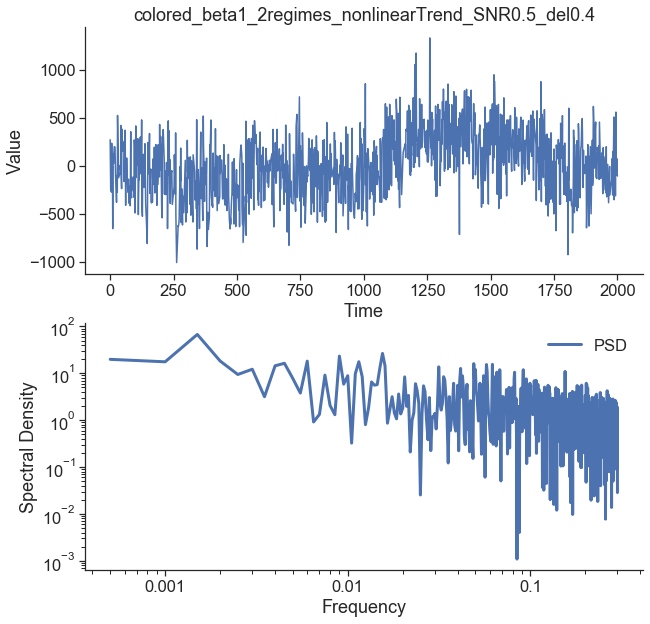

In [12]:
np.random.seed(2333)
case_list = df.columns.values
print(case_list)
for case_tag in tqdm(case_list):
    for del_percent in [0.4]:
        signal = df[case_tag].values
        time = df[case_tag].index
        n_del = int(del_percent*np.size(time))
        deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
        
        time_unevenly =  np.delete(time, deleted_idx)
        signal_unevenly =  np.delete(signal, deleted_idx)

        series = pd.Series(signal_unevenly, index=time_unevenly)
        
        col_tag = f'{case_tag}_del{del_percent}'
        df[col_tag] = series
        
        if 'colored' in case_tag:
            loglog=True
        else:
            loglog=False
            
        fig, res_psd = run_periodogram(series, title=col_tag, loglog=loglog, detrend='hht')

In [13]:
print(len(df.columns))

60
